In [56]:
# import os
# %pwd

In [57]:
# os.chdir('../')
# %pwd

In [67]:
import os 
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    validation_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_image_size: list

@dataclass(frozen=True)
class PrepareCallBacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    checkpoint_model_filepath: Path

In [68]:
from cnnClassifier.constants import *
from cnnClassifier.utils.common import read_yaml, create_directories
import tensorflow as tf


In [69]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])
    
    def get_prepare_callback_config(self) -> PrepareCallBacksConfig:
        config = self.config.prepare_callbacks

        model_ckpt_dir = os.path.dirname(config.checkpoint_model_filepath)
        create_directories([Path(model_ckpt_dir), Path(config.tensorboard_root_log_dir)])

        prepare_callback_config = PrepareCallBacksConfig(
            root_dir = Path(config.root_dir),
            tensorboard_root_log_dir=Path(config.tensorboard_root_log_dir),
            checkpoint_model_filepath=Path(config.checkpoint_model_filepath)
        )

        return prepare_callback_config
    

    def get_training_config(self) -> TrainingConfig:
        training = self.config.training
        prepare_base_model = self.config.prepare_base_model
        params = self.params
        training_data = self.config.data_ingestion
        validation_data = self.config.data_ingestion
        create_directories([training.root_dir])

        training_config = TrainingConfig(
            root_dir = Path(training.root_dir)
            ,trained_model_path = Path(training.trained_model_path)
            ,updated_base_model_path = Path(prepare_base_model.updated_base_model_path)
            ,training_data = Path(training_data.train_dir)
            ,validation_data = Path(validation_data.val_dir)
            ,params_epochs = params.EPOCHS
            ,params_batch_size = params.BATCH_SIZE
            ,params_is_augmentation = params.AUGMENTATION
            ,params_image_size = params.IMAGE_SIZE
        )

        return training_config

# Prepare CallBACKS

In [70]:
import os
import time
import tensorflow as tf
import urllib.request as request


class PrepareCallBack:
    def __init__(self, config: PrepareCallBacksConfig):
        self.config = config

    @property
    def _create_tb_callbacks(self):
        timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
        tb_running_log_dir = os.path.join(
            self.config.tensorboard_root_log_dir,
            f"tb_logs_at_{timestamp}",
        )
        return tf.keras.callbacks.TensorBoard(log_dir=tb_running_log_dir)
    
    @property
    def _create_ckpt_callbacks(self):
        return tf.keras.callbacks.ModelCheckpoint(
            filepath=str(self.config.checkpoint_model_filepath),
            save_best_only=True
        )
    
    def get_tb_ckpt_callbacks(self):
        return [
            self._create_tb_callbacks,
            self._create_ckpt_callbacks,
        ]

############-----------------------------------##################

In [71]:
import matplotlib.pyplot as plt

class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config

    @staticmethod
    def _validate_image_transformation(data_generator, img_idx):

        # Get the list of class names (categories)
        class_names = list(data_generator.class_indices.keys())      

        # Display the first batch of images and their labels
        images, labels = next(data_generator)

        # Convert one-hot encoded labels to class names
        class_labels = [class_names[idx] for idx in tf.argmax(labels, axis=1)]
        print(f'LOG: df size: {len(data_generator.filenames)}')

        # Visualize the first image and its label
        plt.imshow(images[img_idx])
        plt.title(f'Class: {format(class_labels[img_idx])} | Label: {format(labels[img_idx])}')
        plt.axis('off')
        plt.show()

    @staticmethod
    def save_model(path:Path, model: tf.keras.Model):
        model.save(path)    
    
    def get_base_model(self):
        """loading the base model done before | 2:16 min"""

        self.model = tf.keras.models.load_model(self.config.updated_base_model_path)
        print()
    
    def train_valid_generator(self):
        """Create the tranin and test data split if is not done before"""

        datagenerator_kwargs = dict(rescale = 1./225, 
                                    validation_split = 0.20)

        dataflow_kwargs = dict(target_size = self.config.params_image_size[:-1],
                               batch_size = self.config.params_batch_size,
                               interpolation = 'bilinear',
                               class_mode='categorical',
                              ) 
        
        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(**datagenerator_kwargs)

        self.valid_generator = valid_datagenerator.flow_from_directory(directory=self.config.validation_data,
                                                                       #subset='validation',
                                                                       shuffle=False, # Set to False to ensure the order of samples is preserved
                                                                       **dataflow_kwargs)
        # Display the first batch of images and their labels
        # Visualize the first image and its label
        self._validate_image_transformation(data_generator=self.valid_generator, img_idx=0)
        
        
        if self.config.params_is_augmentation:
            train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=40,
                horizontal_flip=True,
                width_shift_range=0.2,
                height_shift_range=0.2,
                zoom_range=0.2,
                **datagenerator_kwargs
            )
        else:
            train_datagenerator = valid_datagenerator
        
        self.train_generator = train_datagenerator.flow_from_directory(
            directory = self.config.training_data,
            #subset='training',
            shuffle=True,
            **dataflow_kwargs
        )
        # Display the first batch of images and their labels
        # Visualize the first image and its label
        self._validate_image_transformation(data_generator=self.train_generator, img_idx=0)


    def train(self, callback_list:list):
        self.steps_per_epoch = self.train_generator.samples // self.train_generator.batch_size
        self.validation_steps = self.valid_generator.samples // self.valid_generator.batch_size

        self.model.fit(
            self.train_generator,
            epochs = self.config.params_epochs,
            steps_per_epoch = self.steps_per_epoch,
            validation_steps = self.validation_steps,
            validation_data = self.valid_generator,
            callbacks = callback_list
        )

        self.save_model(
            path=self.config.trained_model_path,
            model=self.model
        )

[2023-07-27 13:14:19,249: INFO: common: yaml file: config\config.yaml loaded successfully]
[2023-07-27 13:14:19,255: INFO: common: yaml file: params.yaml loaded successfully]
[2023-07-27 13:14:19,258: INFO: common: created directory at: artifacts]
[2023-07-27 13:14:19,265: INFO: common: created directory at: artifacts\prepare_callbacks\checkpoint_dir]
[2023-07-27 13:14:19,268: INFO: common: created directory at: artifacts\prepare_callbacks\tensorboard_log_dir]


[2023-07-27 13:14:21,908: INFO: common: created directory at: artifacts/training]

Found 16 images belonging to 2 classes.
LOG: df size: 16
[2023-07-27 13:14:34,729: WARNING: image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).]


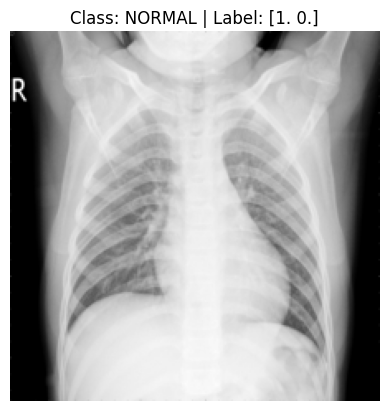

Found 4763 images belonging to 2 classes.
LOG: df size: 4763
[2023-07-27 13:14:53,136: WARNING: image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).]


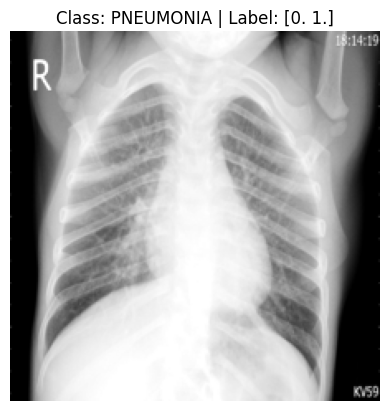

297/297 [==============================] - 975s 3s/step - loss: 2.5891 - accuracy: 0.8492 - val_loss: 0.5417 - val_accuracy: 0.8750


c:\Users\lpaes\projects\Xray_img_detection\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [72]:
try:
    config = ConfigurationManager()
    prepare_callbacks_config = config.get_prepare_callback_config()
    prepare_callbacks = PrepareCallBack(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_callbacks()

    training_config = config.get_training_config()
    training = Training(config=training_config)
    training.get_base_model()
    training.train_valid_generator()
    training.train(
        callback_list=callback_list
    )
    
except Exception as e:
    raise e

In [64]:
print()
'LOG: df size: 4763'

'LOG: df size: 4763'